In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.decomposition import TruncatedSVD

from sklearn.externals import joblib
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler,SMOTE

from random import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

nrow = 80000
number_of_time = 10

In [3]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [44]:
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
            22,24,25,26,27,41,29,
            32,35,37,40,48,49,47,
            55,51,52,53,60,61,62,103,65,66,67,69,
            70,71,74,78,79,
            82,84,89,90,91,94,95,96,97,99,
            105,106,110,111,112,118,119,125,128,
            130,133,134,135,137,138,
            140,144,145,147,151,155,157,159,
            161,162,163,164,167,168,
            170,171,173,175,176,179,
            180,181,184,185,187,189,
            190,191,195,196,199]
reverse_list = ['var_%d'%i for i in reverse_list]
def features_engineer(x,usingModel = False,fs_model = None):
    res_x = x.copy()
    if fs_model is None and usingModel:
        fs_model = TruncatedSVD(n_components=100,algorithm='arpack').fit(x)
        addX_df = pd.DataFrame(fs_model.transform(x),columns=["svd_%d"%i for i in range(100)])
        
        res_x = pd.concat([res_x,addX_df],axis=1)
    elif usingModel:
        addX_df = pd.DataFrame(fs_model.transform(x),columns=["svd_%d"%i for i in range(100)])
        res_x = pd.concat([res_x,addX_df],axis=1)
    
    
    return(res_x,fs_model)

In [32]:
def data_augmentation(x,y,low_class_ratio = 0.2,method = 'none'):
    if method == 'random_under_sample':
        sm = RandomUnderSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'random_over_sample':
        sm = RandomOverSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'smote':
        sm = SMOTE(sampling_strategy=1-low_class_ratio,m_neighbors=10,kind='svm')
        aug_x,aug_y = sm.fit_resample(x,y)
#    elif method == 'shuffle':
        
    else:
        aug_x = x
        aug_y = y
    
    return(pd.DataFrame(aug_x,columns=x.columns),pd.DataFrame(aug_y,columns=['target']))

In [33]:
#test = pd.read_csv('../data/test.csv')
#sub = pd.DataFrame()
#sub['ID_code'] = test['ID_code']
#test.drop('ID_code',axis=1,inplace=True)
train,test = train_test_split(train,test_size = 0.3)

In [60]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)
test_x = test.drop('target',axis=1).reset_index(drop=True)

In [61]:
fe_train_x,svd_model = features_engineer(train_x,True)
fe_test_x = features_engineer(test_x,True,svd_model)[0]

In [63]:
#predict and combine
def models_list_predict(models,test_x):
    res = np.zeros((test.shape[0]))
    for model in models:
        res = res + model.predict(test_x)
    res = res/len(models)
    return(res)

def combine_pred(x,y,test_x):
    pred = np.zeros((test.shape[0]))
    for i in range(number_of_time):
        model = k_fold_train(x,y,'none',random()/2)
        pred = pred + model.predict(test_x)

    pred = pred/number_of_time
    return(pred)

In [67]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.2,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.04,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1,
    "bagging_seed" : 15,
    "seed": 15
}

def k_fold_train(x,y,model_param = param,sample_method = 'none'):
    kf = StratifiedKFold(n_splits=3,shuffle=True)
    models = []
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        n_x,n_y = data_augmentation(train_model_x,train_model_y,method=sample_method,low_class_ratio=random()/2+0.1)
        train_data = lgb.Dataset(n_x,n_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(model_param,train_set=train_data,num_boost_round=100000,verbose_eval = 100,
                          early_stopping_rounds=1000,valid_sets = [train_data,val_data])
        models.append(model)
    return(models)

In [68]:
base_line = k_fold_train(train_x,train_y)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.884244	valid_1's auc: 0.8091
[200]	training's auc: 0.914696	valid_1's auc: 0.845221
[300]	training's auc: 0.925262	valid_1's auc: 0.857662
[400]	training's auc: 0.930988	valid_1's auc: 0.862371
[500]	training's auc: 0.93278	valid_1's auc: 0.866737
[600]	training's auc: 0.93525	valid_1's auc: 0.869975
[700]	training's auc: 0.937621	valid_1's auc: 0.870445
[800]	training's auc: 0.939391	valid_1's auc: 0.872345
[900]	training's auc: 0.940579	valid_1's auc: 0.873822
[1000]	training's auc: 0.941316	valid_1's auc: 0.875301
[1100]	training's auc: 0.942117	valid_1's auc: 0.875012
[1200]	training's auc: 0.942278	valid_1's auc: 0.8753
[1300]	training's auc: 0.942757	valid_1's auc: 0.876256
[1400]	training's auc: 0.94434	valid_1's auc: 0.876974
[1500]	training's auc: 0.944728	valid_1's auc: 0.876891
[1600]	training's auc: 0.944722	valid_1's auc: 0.877402
[1700]	training's auc: 0.945241	valid_1's auc: 0.878166


[7900]	training's auc: 0.971618	valid_1's auc: 0.88112
[8000]	training's auc: 0.971916	valid_1's auc: 0.881131
Early stopping, best iteration is:
[7072]	training's auc: 0.969079	valid_1's auc: 0.881487
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.882762	valid_1's auc: 0.811912
[200]	training's auc: 0.914243	valid_1's auc: 0.843405
[300]	training's auc: 0.923825	valid_1's auc: 0.854543
[400]	training's auc: 0.929355	valid_1's auc: 0.861676
[500]	training's auc: 0.932763	valid_1's auc: 0.865114
[600]	training's auc: 0.934603	valid_1's auc: 0.868807
[700]	training's auc: 0.936387	valid_1's auc: 0.870496
[800]	training's auc: 0.938225	valid_1's auc: 0.873601
[900]	training's auc: 0.93952	valid_1's auc: 0.874784
[1000]	training's auc: 0.940288	valid_1's auc: 0.874413
[1100]	training's auc: 0.941671	valid_1's auc: 0.874478
[1200]	training's auc: 0.941668	valid_1's auc: 0.874263
[1300]	training's auc: 0.942327	valid_1's auc: 0.875392
[1400]	training'

In [69]:
fe_test = k_fold_train(fe_train_x,train_y)
#random_under = k_fold_train(train_x,train_y,'random_under_sample')

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.88307	valid_1's auc: 0.818481
[200]	training's auc: 0.908895	valid_1's auc: 0.845231
[300]	training's auc: 0.917801	valid_1's auc: 0.853783
[400]	training's auc: 0.921911	valid_1's auc: 0.859627
[500]	training's auc: 0.924676	valid_1's auc: 0.861952
[600]	training's auc: 0.927304	valid_1's auc: 0.862486
[700]	training's auc: 0.927746	valid_1's auc: 0.860771
[800]	training's auc: 0.92877	valid_1's auc: 0.860779
[900]	training's auc: 0.929434	valid_1's auc: 0.861179
[1000]	training's auc: 0.93061	valid_1's auc: 0.861712
[1100]	training's auc: 0.932243	valid_1's auc: 0.864548
[1200]	training's auc: 0.934076	valid_1's auc: 0.865824
[1300]	training's auc: 0.935269	valid_1's auc: 0.867068
[1400]	training's auc: 0.936098	valid_1's auc: 0.868801
[1500]	training's auc: 0.936672	valid_1's auc: 0.869504
[1600]	training's auc: 0.937322	valid_1's auc: 0.870296
[1700]	training's auc: 0.937985	valid_1's auc: 0.871

[2100]	training's auc: 0.93985	valid_1's auc: 0.877599
[2200]	training's auc: 0.940864	valid_1's auc: 0.878116
[2300]	training's auc: 0.941384	valid_1's auc: 0.878363
[2400]	training's auc: 0.942236	valid_1's auc: 0.878764
[2500]	training's auc: 0.94268	valid_1's auc: 0.878963
[2600]	training's auc: 0.943166	valid_1's auc: 0.879122
[2700]	training's auc: 0.943947	valid_1's auc: 0.87968
[2800]	training's auc: 0.944478	valid_1's auc: 0.879842
[2900]	training's auc: 0.945181	valid_1's auc: 0.879978
[3000]	training's auc: 0.945881	valid_1's auc: 0.880294
[3100]	training's auc: 0.946469	valid_1's auc: 0.880577
[3200]	training's auc: 0.947108	valid_1's auc: 0.880916
[3300]	training's auc: 0.94765	valid_1's auc: 0.881349
[3400]	training's auc: 0.94816	valid_1's auc: 0.88141
[3500]	training's auc: 0.948761	valid_1's auc: 0.881536
[3600]	training's auc: 0.949421	valid_1's auc: 0.881745
[3700]	training's auc: 0.950027	valid_1's auc: 0.882046
[3800]	training's auc: 0.950665	valid_1's auc: 0.88235

[5900]	training's auc: 0.962996	valid_1's auc: 0.870106
[6000]	training's auc: 0.963363	valid_1's auc: 0.870198
[6100]	training's auc: 0.963732	valid_1's auc: 0.870332
[6200]	training's auc: 0.964125	valid_1's auc: 0.8704
[6300]	training's auc: 0.964557	valid_1's auc: 0.870384
[6400]	training's auc: 0.965053	valid_1's auc: 0.870477
[6500]	training's auc: 0.965381	valid_1's auc: 0.87066
[6600]	training's auc: 0.965761	valid_1's auc: 0.87075
[6700]	training's auc: 0.966167	valid_1's auc: 0.8708
[6800]	training's auc: 0.96667	valid_1's auc: 0.871035
[6900]	training's auc: 0.967053	valid_1's auc: 0.871053
[7000]	training's auc: 0.967404	valid_1's auc: 0.871261
[7100]	training's auc: 0.9678	valid_1's auc: 0.871331
[7200]	training's auc: 0.968162	valid_1's auc: 0.871454
[7300]	training's auc: 0.968488	valid_1's auc: 0.871753
[7400]	training's auc: 0.968886	valid_1's auc: 0.871674
[7500]	training's auc: 0.969254	valid_1's auc: 0.871891
[7600]	training's auc: 0.969616	valid_1's auc: 0.871974
[

In [70]:
#random_over = k_fold_train(train_x,train_y,'random_over_sample')

In [71]:
#smote = k_fold_train(train_x,train_y,'smote')

In [72]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [73]:
pred = models_list_predict(base_line,test_x)

result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = pred

In [74]:
#pred = random_under.predict(test.drop('target',axis=1))
#result_df['random_under'] = pred

pred = models_list_predict(fe_test,fe_test_x)
result_df['feature_test'] = pred

#pred = models_list_predict(smote,test.drop('target',axis=1))
#result_df['smote'] = pred

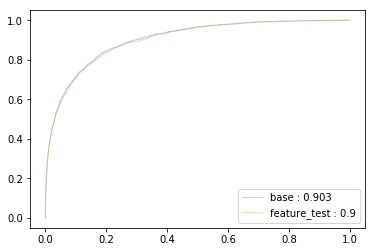

,models,auc_score
0,base,0.903079
1,feature_test,0.900455


In [75]:
plotGraph(result_df)

In [11]:
#final_pred = combine_pred(x,y,test)
final_pred = models_list_predict(base_line,test)

In [12]:
sub['target'] = final_pred
sub.to_csv("../data/models_list_pred_base.csv",index=False)